Demand Predict

Basic Data Preparation

In [1]:
from pandas import read_csv
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [2]:
dataset = read_csv('~/work/DemandPrediction/2016demand2017.csv')

In [3]:
# manually specify column names
dataset.columns = ['date', 'quantity']
dataset.index.name = 'date'
dataset.head(5)

,date,quantity
date,,
0,2016-01-01,3
1,2016-01-02,2
2,2016-01-03,0
3,2016-01-04,2
4,2016-01-05,0


In [4]:
from matplotlib import pyplot
# load dataset
#dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values

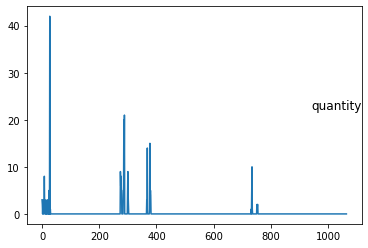

In [5]:

# plot each column
pyplot.figure()
pyplot.plot(values[:, 1])
pyplot.title(dataset.columns[1], y=0.5, loc='right')
pyplot.show()

Multivariate LSTM Forecast Model

LSTM Data Preparation:<br>
***framing the dataset as a supervised learning problem and normalizing the input variables.***

In [6]:
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

In [7]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 

In [8]:
# integer encode direction
encoder = LabelEncoder()
values[:,0] = encoder.fit_transform(values[:,0])

In [9]:
values

array([[0, 3],
       [1, 2],
       [2, 0],
       ...,
       [1062, 0],
       [1063, 0],
       [1064, 0]], dtype=object)

In [10]:
# ensure all data is float
values = values.astype('float32')

In [11]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [12]:
#1month
num_lags = 30
num_features=1
# frame as supervised learning
reframed = series_to_supervised(scaled, num_lags, 1)

In [13]:
reframed.head(10)

,var1(t-30),var2(t-30),var1(t-29),var2(t-29),var1(t-28),var2(t-28),var1(t-27),var2(t-27),var1(t-26),var2(t-26),...,var1(t-4),var2(t-4),var1(t-3),var2(t-3),var1(t-2),var2(t-2),var1(t-1),var2(t-1),var1(t),var2(t)
30,0.000000,0.071429,0.000940,0.047619,0.001880,0.000000,0.002820,0.047619,0.003759,0.000000,...,0.024436,0.00000,0.025376,1.00000,0.026316,0.00000,0.027256,0.02381,0.028195,0.0
31,0.000940,0.047619,0.001880,0.000000,0.002820,0.047619,0.003759,0.000000,0.004699,0.071429,...,0.025376,1.00000,0.026316,0.00000,0.027256,0.02381,0.028195,0.00000,0.029135,0.0
32,0.001880,0.000000,0.002820,0.047619,0.003759,0.000000,0.004699,0.071429,0.005639,0.071429,...,0.026316,0.00000,0.027256,0.02381,0.028195,0.00000,0.029135,0.00000,0.030075,0.0
33,0.002820,0.047619,0.003759,0.000000,0.004699,0.071429,0.005639,0.071429,0.006579,0.000000,...,0.027256,0.02381,0.028195,0.00000,0.029135,0.00000,0.030075,0.00000,0.031015,0.0
34,0.003759,0.000000,0.004699,0.071429,0.005639,0.071429,0.006579,0.000000,0.007519,0.190476,...,0.028195,0.00000,0.029135,0.00000,0.030075,0.00000,0.031015,0.00000,0.031955,0.0
35,0.004699,0.071429,0.005639,0.071429,0.006579,0.000000,0.007519,0.190476,0.008459,0.047619,...,0.029135,0.00000,0.030075,0.00000,0.031015,0.00000,0.031955,0.00000,0.032895,0.0
36,0.005639,0.071429,0.006579,0.000000,0.007519,0.190476,0.008459,0.047619,0.009398,0.071429,...,0.030075,0.00000,0.031015,0.00000,0.031955,0.00000,0.032895,0.00000,0.033835,0.0
37,0.006579,0.000000,0.007519,0.190476,0.008459,0.047619,0.009398,0.071429,0.010338,0.000000,...,0.031015,0.00000,0.031955,0.00000,0.032895,0.00000,0.033835,0.00000,0.034774,0.0
38,0.007519,0.190476,0.008459,0.047619,0.009398,0.071429,0.010338,0.000000,0.011278,0.000000,...,0.031955,0.00000,0.032895,0.00000,0.033835,0.00000,0.034774,0.00000,0.035714,0.0
39,0.008459,0.047619,0.009398,0.071429,0.010338,0.000000,0.011278,0.000000,0.012218,0.047619,...,0.032895,0.00000,0.033835,0.00000,0.034774,0.00000,0.035714,0.00000,0.036654,0.0


In [14]:
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
#print(reframed.head())

In [15]:
values = reframed.values
values.shape

(1035, 62)

Define and Fit Model

In [16]:
import math
# split into train and test sets
values = reframed.values
train_size = math.floor(values.shape[0] *0.6)
test_size = math.floor(values.shape[0]*0.2)
#n_train_day = 20
train = values[:train_size,:]
test = values[train_size:(train_size+test_size), :]
cross_validation = values[(train_size+test_size):, :]



In [17]:
# split into input and outputs
n_obs = num_lags * num_features
train_X, train_y = train[:, :n_obs], train[:, -num_features]
test_X, test_y = test[:, :n_obs], test[:, -num_features]
cross_X, cross_y = cross_validation[:, :n_obs], cross_validation[:, -num_features]
print(train_X.shape, len(train_X), train_y.shape)

(621, 30) 621 (621,)


In [18]:
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(621, 30) (621,) (207, 30) (207,)


In [19]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], num_lags, num_features))
test_X = test_X.reshape((test_X.shape[0], num_lags, num_features))
cross_X = cross_X.reshape((cross_X.shape[0], num_lags, num_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(621, 30, 1) (621,) (207, 30, 1) (207,)


In [20]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [21]:
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/50
9/9 - 0s - loss: 0.0092 - val_loss: 0.0070
Epoch 2/50
9/9 - 0s - loss: 0.0172 - val_loss: 0.0032
Epoch 3/50
9/9 - 0s - loss: 0.0112 - val_loss: 0.0052
Epoch 4/50
9/9 - 0s - loss: 0.0152 - val_loss: 0.0117
Epoch 5/50
9/9 - 0s - loss: 0.0112 - val_loss: 0.0047
Epoch 6/50
9/9 - 0s - loss: 0.0076 - val_loss: 0.0046
Epoch 7/50
9/9 - 0s - loss: 0.0132 - val_loss: 0.0053
Epoch 8/50
9/9 - 0s - loss: 0.0113 - val_loss: 0.0059
Epoch 9/50
9/9 - 0s - loss: 0.0069 - val_loss: 0.0046
Epoch 10/50
9/9 - 0s - loss: 0.0131 - val_loss: 0.0118
Epoch 11/50
9/9 - 0s - loss: 0.0086 - val_loss: 0.0033
Epoch 12/50
9/9 - 0s - loss: 0.0070 - val_loss: 0.0040
Epoch 13/50
9/9 - 0s - loss: 0.0071 - val_loss: 0.0037
Epoch 14/50
9/9 - 0s - loss: 0.0090 - val_loss: 0.0101
Epoch 15/50
9/9 - 0s - loss: 0.0096 - val_loss: 0.0046
Epoch 16/50
9/9 - 0s - loss: 0.0117 - val_loss: 0.0062
Epoch 17/50
9/9 - 0s - loss: 0.0103 - val_loss: 0.0087
Epoch 18/50
9/9 - 0s - loss: 0.0099 - val_loss: 0.0033
Epoch 19/50
9/9 - 0

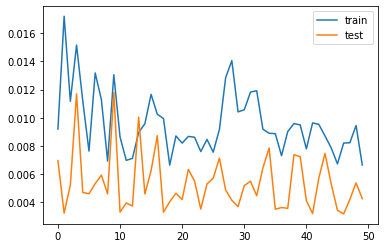

In [22]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Evaluate Model

In [23]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], num_lags*num_features))

In [24]:
from numpy import concatenate
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -1:]), axis=1)
print(inv_yhat.shape)


(207, 2)


In [25]:
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [26]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [27]:
from math import sqrt
from sklearn.metrics import mean_squared_error
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 21.910


In [28]:
rmse = rmse* (1/100)

In [29]:
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.219


In [30]:
#save model
model.save("./model.h5")

In [31]:
from keras.models import load_model
# load model
model = load_model('model.h5')
# summarize model.
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [32]:
cross_validation
yhat = model.predict(cross_X)


In [33]:
yhat

array([[-0.00207534],
       [-0.00208285],
       [-0.00209037],
       [-0.00209791],
       [-0.00210546],
       [-0.00211301],
       [-0.00212057],
       [-0.00212815],
       [-0.00213573],
       [-0.00214333],
       [-0.00215094],
       [-0.00215856],
       [-0.00216618],
       [-0.00217381],
       [-0.00218147],
       [-0.00218913],
       [-0.00219679],
       [-0.00220446],
       [-0.00221216],
       [-0.00221986],
       [-0.00222756],
       [-0.00223528],
       [-0.00224301],
       [-0.00225075],
       [-0.0022585 ],
       [-0.00226626],
       [-0.00227403],
       [-0.00228182],
       [-0.00228962],
       [-0.00229741],
       [-0.00230522],
       [-0.00231305],
       [-0.00232087],
       [-0.00232871],
       [-0.00233656],
       [-0.00234443],
       [-0.00235231],
       [-0.00236019],
       [-0.00236808],
       [-0.00237598],
       [-0.00238389],
       [-0.00239183],
       [-0.00239976],
       [-0.0024077 ],
       [-0.00241566],
       [-0

In [34]:
#cross_validation.to_csv("cross.csv")

In [35]:
import pandas
df = pandas.DataFrame(cross_validation)

In [36]:
df.to_csv('~/work/Data/test.csv')

In [37]:
cross_X.shape

(207, 30, 1)

In [38]:
cross_X = cross_X.reshape((cross_X.shape[0], num_lags*num_features))
from numpy import concatenate
# invert scaling for forecast
inv_yhat = concatenate((yhat, cross_X[:, -1:]), axis=1)
print(inv_yhat.shape)


(207, 2)


In [39]:
inv_yhat

array([[-0.00207534,  0.        ],
       [-0.00208285,  0.        ],
       [-0.00209037,  0.        ],
       [-0.00209791,  0.        ],
       [-0.00210546,  0.        ],
       [-0.00211301,  0.        ],
       [-0.00212057,  0.        ],
       [-0.00212815,  0.        ],
       [-0.00213573,  0.        ],
       [-0.00214333,  0.        ],
       [-0.00215094,  0.        ],
       [-0.00215856,  0.        ],
       [-0.00216618,  0.        ],
       [-0.00217381,  0.        ],
       [-0.00218147,  0.        ],
       [-0.00218913,  0.        ],
       [-0.00219679,  0.        ],
       [-0.00220446,  0.        ],
       [-0.00221216,  0.        ],
       [-0.00221986,  0.        ],
       [-0.00222756,  0.        ],
       [-0.00223528,  0.        ],
       [-0.00224301,  0.        ],
       [-0.00225075,  0.        ],
       [-0.0022585 ,  0.        ],
       [-0.00226626,  0.        ],
       [-0.00227403,  0.        ],
       [-0.00228182,  0.        ],
       [-0.00228962,

In [40]:
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [41]:
inv_yhat

array([-2.2081568, -2.2161567, -2.224158 , -2.2321794, -2.240205 ,
       -2.2482426, -2.2562902, -2.2643497, -2.2724202, -2.2805047,
       -2.2885969, -2.2967033, -2.3048117, -2.3129318, -2.3210802,
       -2.3292334, -2.3373804, -2.3455484, -2.3537352, -2.3619263,
       -2.3701267, -2.378341 , -2.386561 , -2.394803 , -2.4030423,
       -2.411299 , -2.4195697, -2.4278545, -2.4361506, -2.444439 ,
       -2.4527535, -2.4610808, -2.4694088, -2.4777508, -2.4860992,
       -2.494474 , -2.502857 , -2.5112412, -2.5196347, -2.5280445,
       -2.5364625, -2.5449038, -2.553348 , -2.5617948, -2.5702622,
       -2.5787349, -2.5872157, -2.5957203, -2.6042213, -2.6127408,
       -2.6212797, -2.6298163, -2.6383595, -2.646923 , -2.6554914,
       -2.6640792, -2.672679 , -2.6812801, -2.6898932, -2.6985285,
       -2.7071679, -2.7158036, -2.7244718, -2.7331436, -2.7418199,
       -2.7505088, -2.7592163, -2.7679305, -2.7766545, -2.7853835,
       -2.7941313, -2.8028915, -2.811661 , -2.8204327, -2.8292

(585, 90) 585 (585,)
(585, 90, 1) (585,) (195, 90, 1) (195,)
Epoch 1/50
9/9 - 0s - loss: 0.0101 - val_loss: 0.0053
Epoch 2/50
9/9 - 0s - loss: 0.0190 - val_loss: 0.0059
Epoch 3/50
9/9 - 0s - loss: 0.0134 - val_loss: 0.0036
Epoch 4/50
9/9 - 0s - loss: 0.0097 - val_loss: 0.0095
Epoch 5/50
9/9 - 0s - loss: 0.0146 - val_loss: 0.0098
Epoch 6/50
9/9 - 0s - loss: 0.0075 - val_loss: 0.0042
Epoch 7/50
9/9 - 0s - loss: 0.0081 - val_loss: 0.0063
Epoch 8/50
9/9 - 0s - loss: 0.0105 - val_loss: 0.0063
Epoch 9/50
9/9 - 0s - loss: 0.0099 - val_loss: 0.0055
Epoch 10/50
9/9 - 0s - loss: 0.0078 - val_loss: 0.0058
Epoch 11/50
9/9 - 0s - loss: 0.0107 - val_loss: 0.0047
Epoch 12/50
9/9 - 0s - loss: 0.0101 - val_loss: 0.0048
Epoch 13/50
9/9 - 0s - loss: 0.0096 - val_loss: 0.0076
Epoch 14/50
9/9 - 0s - loss: 0.0103 - val_loss: 0.0060
Epoch 15/50
9/9 - 0s - loss: 0.0093 - val_loss: 0.0044
Epoch 16/50
9/9 - 0s - loss: 0.0088 - val_loss: 0.0063
Epoch 17/50
9/9 - 0s - loss: 0.0114 - val_loss: 0.0054
Epoch 18/50
9

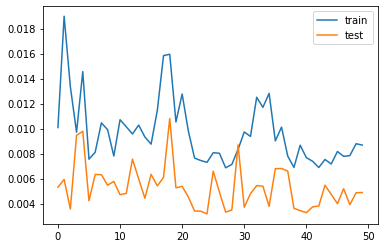

In [42]:
#90 days 
num_lags = 90
num_features=1
# frame as supervised learning
reframed = series_to_supervised(scaled, num_lags, 1)
values = reframed.values
values = reframed.values
train_size = math.floor(values.shape[0] *0.6)
test_size = math.floor(values.shape[0]*0.2)
#n_train_day = 20
train = values[:train_size,:]
test = values[train_size:(train_size+test_size), :]
cross_validation = values[(train_size+test_size):, :]

# split into input and outputs
n_obs = num_lags * num_features
train_X, train_y = train[:, :n_obs], train[:, -num_features]
test_X, test_y = test[:, :n_obs], test[:, -num_features]
cross_X, cross_y = cross_validation[:, :n_obs], cross_validation[:, -num_features]
print(train_X.shape, len(train_X), train_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], num_lags, num_features))
test_X = test_X.reshape((test_X.shape[0], num_lags, num_features))
cross_X = cross_X.reshape((cross_X.shape[0], num_lags, num_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
#save model
model.save("./model-90days.h5")

(420, 365) 420 (420,)
(420, 365, 1) (420,) (140, 365, 1) (140,)
Epoch 1/50
6/6 - 1s - loss: 0.0148 - val_loss: 0.0130
Epoch 2/50
6/6 - 1s - loss: 0.0114 - val_loss: 0.0012
Epoch 3/50
6/6 - 1s - loss: 0.0166 - val_loss: 0.0056
Epoch 4/50
6/6 - 1s - loss: 0.0136 - val_loss: 0.0120
Epoch 5/50
6/6 - 1s - loss: 0.0052 - val_loss: 6.4749e-04
Epoch 6/50
6/6 - 1s - loss: 0.0079 - val_loss: 0.0015
Epoch 7/50
6/6 - 1s - loss: 0.0050 - val_loss: 0.0015
Epoch 8/50
6/6 - 1s - loss: 0.0052 - val_loss: 0.0033
Epoch 9/50
6/6 - 1s - loss: 0.0069 - val_loss: 0.0014
Epoch 10/50
6/6 - 1s - loss: 0.0069 - val_loss: 7.4724e-04
Epoch 11/50
6/6 - 1s - loss: 0.0072 - val_loss: 0.0048
Epoch 12/50
6/6 - 1s - loss: 0.0056 - val_loss: 0.0012
Epoch 13/50
6/6 - 1s - loss: 0.0053 - val_loss: 0.0048
Epoch 14/50
6/6 - 1s - loss: 0.0061 - val_loss: 3.9790e-04
Epoch 15/50
6/6 - 1s - loss: 0.0049 - val_loss: 0.0019
Epoch 16/50
6/6 - 1s - loss: 0.0051 - val_loss: 9.7296e-04
Epoch 17/50
6/6 - 1s - loss: 0.0051 - val_loss: 0

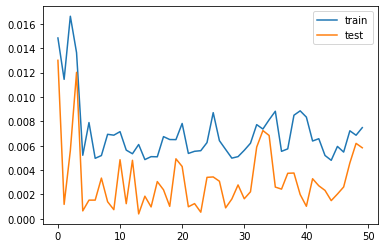

In [44]:
#90 days 
num_lags = 365
num_features=1
# frame as supervised learning
reframed = series_to_supervised(scaled, num_lags, 1)
values = reframed.values
values = reframed.values
train_size = math.floor(values.shape[0] *0.6)
test_size = math.floor(values.shape[0]*0.2)
#n_train_day = 20
train = values[:train_size,:]
test = values[train_size:(train_size+test_size), :]
cross_validation = values[(train_size+test_size):, :]

# split into input and outputs
n_obs = num_lags * num_features
train_X, train_y = train[:, :n_obs], train[:, -num_features]
test_X, test_y = test[:, :n_obs], test[:, -num_features]
cross_X, cross_y = cross_validation[:, :n_obs], cross_validation[:, -num_features]
print(train_X.shape, len(train_X), train_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], num_lags, num_features))
test_X = test_X.reshape((test_X.shape[0], num_lags, num_features))
cross_X = cross_X.reshape((cross_X.shape[0], num_lags, num_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
#save model
model.save("./model-365days.h5")